In [2]:
%matplotlib qt
import mne
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt

# Loading 

In [3]:
participant_id = '02'
motor_task = 'motoreal' 
file_name = f"Data/Raw/{participant_id}/BHIe_{participant_id}_{motor_task}.bdf"

# Load the raw data
raw = mne.io.read_raw_bdf(file_name, preload=True)

Extracting EDF parameters from /home/oem/Documents/HBI-motor_imagery/HBI-motor_imagery/src/preprocessing/Data/Raw/02/BHIe_02_motoreal.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 444415  =      0.000 ...   433.999 secs...


# Processing

1. Events
- motoreal:     Left = 110 / Right = 120
- motorimagery: Left = 210 / Right = 220

In [4]:
from preprocessing.utils import extract_emg_data, extract_ecg_data

In [5]:
# 1. Get the events
events = mne.find_events(raw, initial_event=True) # Store events
events[:, 2] &= (2**9-1) # Modify event data

# 2. Set the EEG reference channels
mne.set_eeg_reference(inst=raw, ref_channels=["EXG1", "EXG2"])

# 3. Get external channels
channel_list = raw.info['ch_names'][:-1] # The full list of channels
ext_channels = channel_list[-8:] # The external channels (EXG1-8)
status = raw.info['ch_names'][-1] # Can be deleted after the events have been extracted

# 4. Extract the datasets (EMG, ECG)
if participant_id != '23':
    emg_data = extract_emg_data(raw_dataset=raw)
else:
    emg_data = extract_emg_data(raw_dataset=raw, inverse=True)


# ECG channels have been inverted in participant 27
if (participant_id != '27'):
    ecg_data = extract_ecg_data(raw_dataset=raw)
else:
    ecg_data = extract_ecg_data(raw_dataset=raw, inverse=True)


# 5. Extract only the EEG data (drop ext. channels)
eeg_data = raw.drop_channels(ext_channels) # not including EXG1-EXG2
eeg_data.drop_channels(status)

103 events found
Event IDs: [ 61441  61550  61560 126976]
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawEDF | BHIe_02_motoreal.bdf, 64 x 444416 (434.0 s), ~217.1 MB, data loaded>

## Preprocess raw data 


In [6]:
from preprocessing.utils import smooth_emg_signal, create_new_raw_dataset

In [7]:
sfreq = raw.info['sfreq']

In [8]:
# EMG DATA (band-pass filter, full-wave rectification, and smooth signal with RMS)
emg_data = mne.filter.filter_data(data=emg_data, sfreq=sfreq, l_freq=10., h_freq=500.)
emg_data = np.abs(emg_data)
emg_data = smooth_emg_signal(emg_data=emg_data, 
                            window_size=int(sfreq/20))


# EEG DATA: Band-pass filter
eeg_data = eeg_data.filter(1., 40., picks=('eeg'), fir_design='firwin')

# ECG DATA: Remove DC offset and Baseline Wander
ecg_data = mne.filter.filter_data(data=ecg_data, sfreq=sfreq, l_freq=0.2, h_freq=40.)

# Combine the data into a new Raw object
filtered_dataset = create_new_raw_dataset(eeg_data=eeg_data, ecg_data=ecg_data, emg_data=emg_data)

# Set the BioSemi 64 Montage
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
filtered_dataset.set_montage(biosemi_montage)


Setting up band-pass filter from 10 - 5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 500.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 506.00 Hz)
- Filter length: 1353 samples (1.321 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Setting up band-pass filter from 0.2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16897 samples (16.501 sec)



[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=67, n_times=444416
    Range : 0 ... 444415 =      0.000 ...   433.999 secs
Ready.


<RawArray | 67 x 444416 (434.0 s), ~227.3 MB, data loaded>

## Epoching (-1, +4s)

In [9]:
# Define the Epoching params
tmin = -1 # min time before the cue
tmax = 4 # max time after the cue
baseline = (None, None)
event_id = {'left': 110, 'right': 120} # 210 and 220 in the MI task

# Generate the mne Epochs data structure
epochs = mne.Epochs(raw=filtered_dataset, 
                    events=events, 
                    event_id=event_id, 
                    tmin=tmin,
                    tmax=tmax,
                    baseline=baseline, 
                    preload=True)

# Name epochs for later use
epochs.name = 'motorexecution' # or motorimagery

Not setting metadata
50 matching events found
Setting baseline interval to [-1.0, 4.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 50 events and 5121 original time points ...
0 bad epochs dropped


## Artefact Correction (FastICA)

In [10]:
from mne.preprocessing import ICA

Fitting ICA to data using 64 channels (please be patient, this may take a while)


/tmp/ipykernel_10765/2245317582.py:10: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(inst=epochs, decim=3)
/tmp/ipykernel_10765/2245317582.py:10: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(inst=epochs, decim=3)


Selecting by number: 10 components
Fitting ICA took 3.7s.
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Using matplotlib as 2D backend.


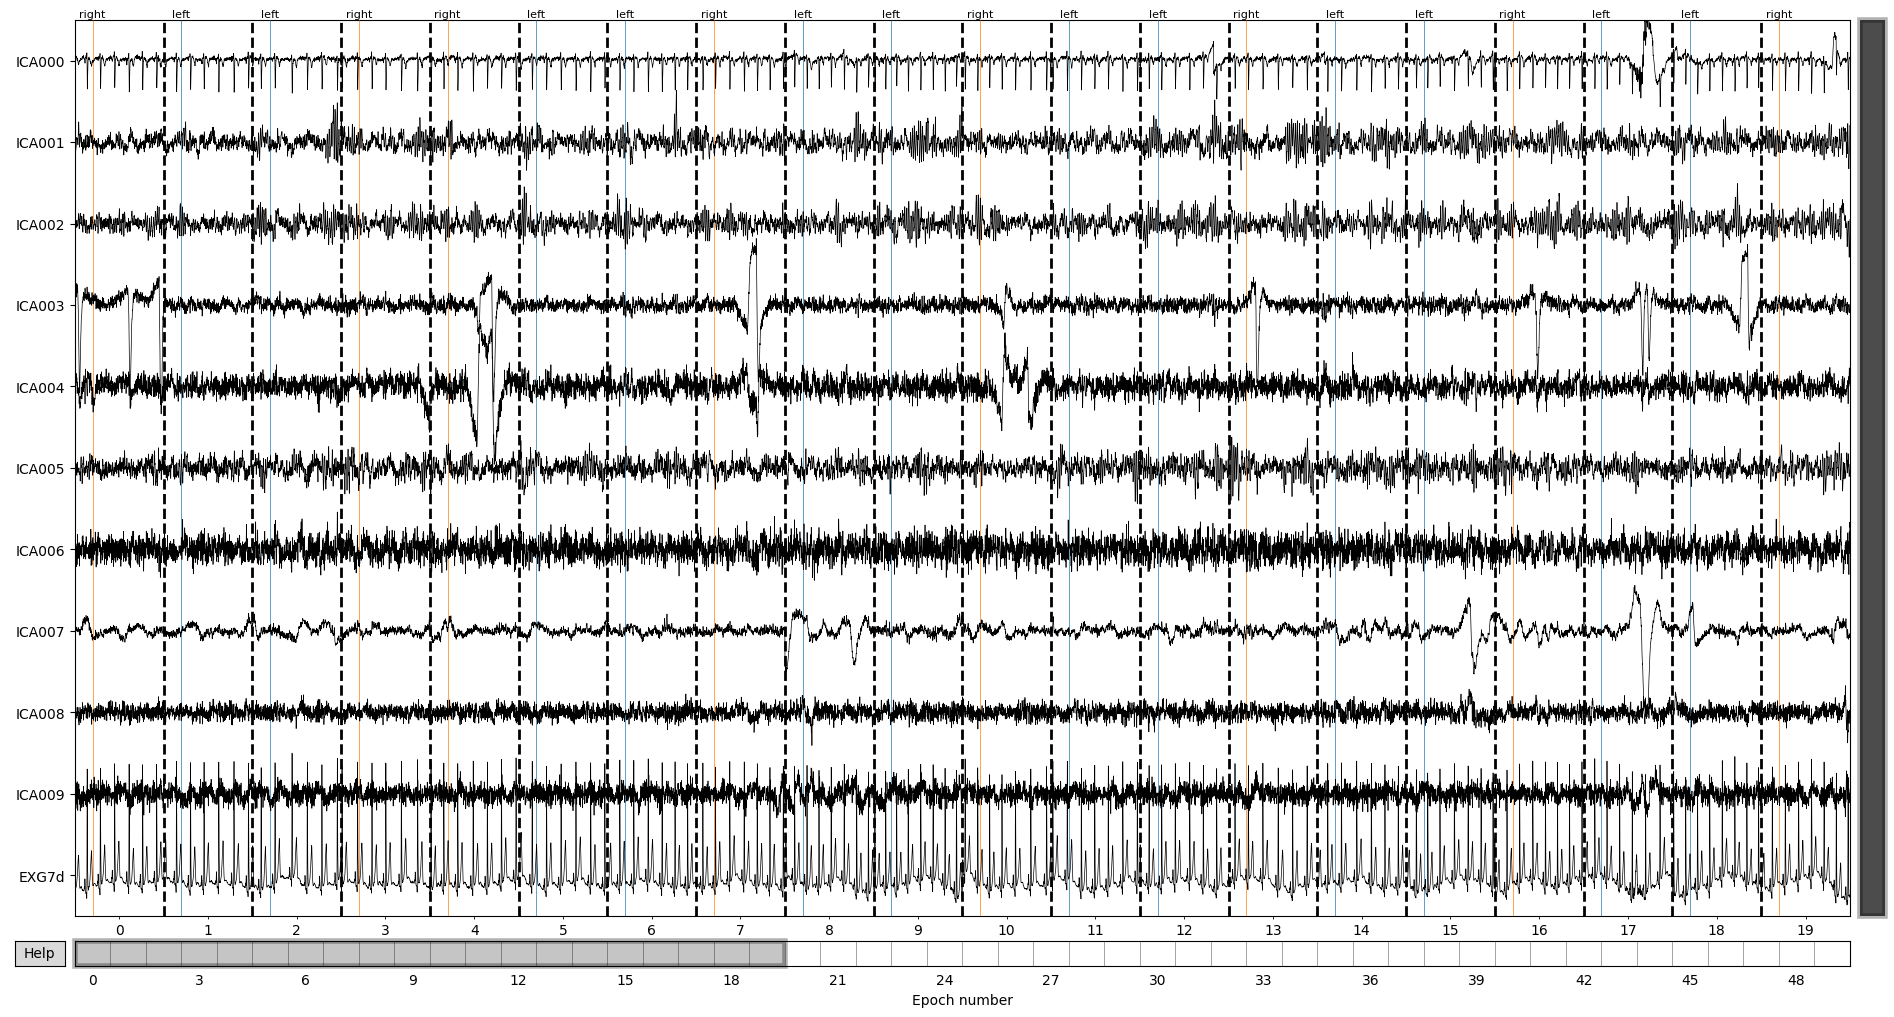

In [11]:
# check for correct sfreq based for sanity check
if epochs.info['sfreq'] != 1024.0:
    epochs.resample(1024.) 

# Instantiate the ICA object
n_components = 10 # plot the first 10 for speed reason
ica = ICA(n_components=n_components, method='fastica', max_iter=800, random_state=92)

# fit ICA
ica.fit(inst=epochs, decim=3)

# Plot and inspect components to decide which to reject (eye-blink, eye-saccades)
ica.plot_components() # plot topographic maps
ica.plot_sources(epochs) #  plot the time-course

In [12]:
# Make a copy in case we want to compare the data before and after 
corrected_epochs = epochs.copy()

# Exclude selected components
components_to_exclude = [3] # eye blink
ica.exclude = components_to_exclude
# Apply the exclusion to the new copy of epochs
ica.apply(corrected_epochs)

Applying ICA to Epochs instance


/tmp/ipykernel_10765/3406955528.py:8: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(corrected_epochs)


    Transforming to ICA space (10 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


Number of events,50
Events,left: 25right: 25
Time range,-1.000 – 4.000 sec
Baseline,-1.000 – 4.000 sec


## Regress ECG

In [13]:
from preprocessing.regress_ecg import regress_ecg

In [29]:
# Apply regress ECG to correct for the Cardiac Field Artefact

regressed_epochs, r_peaks_events = regress_ecg(ecg_data_raw=ecg_data[0, :], epochs=corrected_epochs)

### Plot Regress ECG

- Plot the R-peak locked ERP before and after the regression

In [36]:
import neurokit2 as nk
import matplotlib.pyplot as plt

In [39]:
# extract data before and after regression
data_before = epochs.get_data('eeg')
data_after = regressed_epochs.copy()

rpeak_locked_before = np.zeros(shape=(data_before.shape[0], data_before.shape[1], 1024))
rpeak_locked_after = np.zeros(shape=(data_before.shape[0], data_before.shape[1], 1024))

time = corrected_epochs.times
tzero = np.where(time == 0.0)[0][0] # time of cue presentation
events = corrected_epochs.events

for n_epoch in range(0, data_before.shape[0]):

    # Shift the data around the r-peak
    r_peak_event = r_peaks_events[n_epoch]

    # Get the distance from the cue 
    distance_from_cue = r_peak_event - events[n_epoch, 0]

    before_idx = (tzero + distance_from_cue) - 512 # - 1 second
    after_idx = (tzero + distance_from_cue) + 512

    before_temp = data_before[n_epoch, :, before_idx:after_idx]
    rpeak_locked_before[n_epoch, :, :] = before_temp

    after_temp = data_after[n_epoch, :, before_idx:after_idx]
    rpeak_locked_after[n_epoch, :, :] = after_temp

# ecg[0, 0, :].shape

time_rpeaks = time[512:1024+512]

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(time_rpeaks,  rpeak_locked_before.mean(axis=0).mean(axis=0), lw=4, color='#4C829B', label='original')
plt.plot(time_rpeaks, rpeak_locked_after.mean(axis=0).mean(axis=0), lw=4, color='#705F4A', label='regressed')
plt.xticks([])
plt.yticks(fontsize=25)
plt.subplot(2, 1, 2)
plt.plot(time_rpeaks, ecg_data[0, r_peaks_events[0]-512:r_peaks_events[0]+512], lw=4, color='#3A4246')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend()
plt.show()
    